In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt


In [2]:
# === CONFIG FLAGS ===
ANNOTATE_VIDEO = True  # Set to False if you don't want to save or draw video
video_path = "walking.mp4"
output_video_path = "walking_output.mp4"

In [3]:
# Initialize MediaPipe Pose for pose detection
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils  # (Optional) used for drawing pose landmarks

In [4]:
# === Step 1: Load the presentation video ===
cap = cv2.VideoCapture(video_path)

In [5]:
# Get video metadata
fps = cap.get(cv2.CAP_PROP_FPS) # Frames per second
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # Width of the video frames
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # Height of the video frames
frame_count = 0

In [6]:
# Only create video writer if annotation is enabled
if ANNOTATE_VIDEO:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

In [7]:
# === Tracking Data ===
positions = []        # Normalized horizontal positions per frame
trail_pixels = []     # Pixel positions for visual trail
movement_by_second = []

In [8]:
# === Process Video Frame-by-Frame ===
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

    frame_sec = int(frame_count / fps)

    if results.pose_landmarks:
        # Draw landmarks and center if annotation is enabled
        if ANNOTATE_VIDEO:
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Get shoulder landmarks
        left = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
        right = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]

        # Calculate normalized and pixel center
        norm_x = (left.x + right.x) / 2
        positions.append((frame_sec, norm_x))

        center_x = int(norm_x * width)
        center_y = int((left.y + right.y) / 2 * height)
        trail_pixels.append((center_x, center_y))

        if ANNOTATE_VIDEO:
            cv2.circle(frame, (center_x, center_y), 6, (0, 0, 255), -1)
    else:
        positions.append((frame_sec, None))

    # Draw movement trail (blue lines)
    if ANNOTATE_VIDEO:
        for i in range(1, len(trail_pixels)):
            cv2.line(frame, trail_pixels[i - 1], trail_pixels[i], (255, 0, 0), 2)
        out.write(frame)
    
    # Count frame
    frame_count += 1

cap.release()
if ANNOTATE_VIDEO:
    out.release()
    print("✅ Annotated video saved:", output_video_path)

✅ Annotated video saved: walking_output.mp4


In [9]:
# === Step 3: Aggregate positions per second ===

# Calculate total number of seconds in the video
seconds = int(frame_count / fps)

In [10]:

for sec in range(seconds):
    sec_positions = [p for t, p in positions if t == sec and p is not None]

    if sec_positions:
        # Calculate average X position for the second
        avg_position = sum(sec_positions) / len(sec_positions)
        movement_by_second.append((sec, avg_position))
    else:
        # No position detected in this second
        movement_by_second.append((sec, None))

In [11]:
# === Step 4: Output movement data ===

# Print the second-by-second normalized horizontal position
print("\n=== Presenter Movement Summary ===")
for timestamp, pos in movement_by_second:
    if pos is not None:
        print(f"Second {timestamp}: Normalized X Position = {pos:.3f}")
    else:
        print(f"Second {timestamp}: No presenter detected")


=== Presenter Movement Summary ===
Second 0: Normalized X Position = 0.532
Second 1: Normalized X Position = 0.063
Second 2: Normalized X Position = 0.133
Second 3: Normalized X Position = 0.229
Second 4: Normalized X Position = 0.328
Second 5: Normalized X Position = 0.434
Second 6: Normalized X Position = 0.540
Second 7: Normalized X Position = 0.648
Second 8: Normalized X Position = 0.759


# Show Lineplot

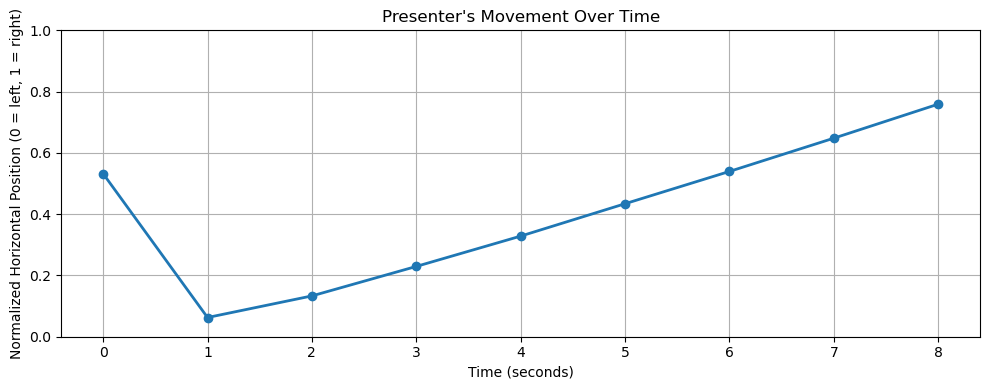

In [12]:
# Extract timestamps and positions (excluding None)
timestamps = [t for t, p in movement_by_second if p is not None]
positions = [p for t, p in movement_by_second if p is not None]

# Create the line plot
plt.figure(figsize=(10, 4))
plt.plot(timestamps, positions, marker='o', linestyle='-', linewidth=2)

plt.title("Presenter's Movement Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Normalized Horizontal Position (0 = left, 1 = right)")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# Show Heatmap

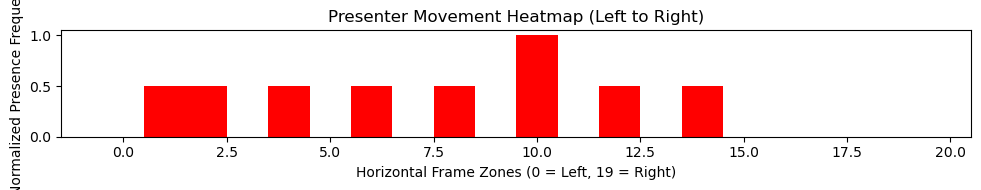

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Set the resolution of the heatmap (e.g., 10 bins across the screen width)
num_bins = 20
heatmap = np.zeros(num_bins)

# Fill the heatmap based on position per second
for sec, pos in movement_by_second:
    if pos is not None:
        bin_index = int(pos * (num_bins - 1))
        heatmap[bin_index] += 1  # Count how often the presenter was in this zone

# Normalize for display
heatmap_normalized = heatmap / np.max(heatmap)

# === Plotting the 1D heatmap ===
plt.figure(figsize=(10, 2))
plt.bar(range(num_bins), heatmap_normalized, width=1.0, color='red')
plt.title("Presenter Movement Heatmap (Left to Right)")
plt.xlabel("Horizontal Frame Zones (0 = Left, 19 = Right)")
plt.ylabel("Normalized Presence Frequency")
plt.tight_layout()
plt.show()